# **Import All Required Libraries**

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
import pickle
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [52]:
df = pd.read_csv('spam.csv', encoding='latin-1')
df.sample(5)

,Category,Message
577,ham,I'm tired of arguing with you about this week ...
1775,ham,"Its ok chikku, and its my 1 of favourite song...."
4115,ham,Where are you ? What do you do ? How can you s...
1307,spam,Enjoy the jamster videosound gold club with yo...
4589,ham,I wanted to wish you a Happy New Year and I wa...


In [53]:
df.shape

(5572, 2)

#**Data Cleaning**

In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  5572 non-null   object
 1   Message   5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [57]:
df = pd.read_csv('spam.csv')
df.columns = ['target', 'text']
df['target'] = df['target'].map({'ham': 0, 'spam': 1})
df.head()


,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [58]:
# missing values
df.isnull().sum()

,0
target,0
text,0


In [59]:
# check for duplicate values
df.duplicated().sum()

np.int64(415)

In [60]:
# remove duplicates
df = df.drop_duplicates(keep='first')

In [61]:
df.duplicated().sum()

np.int64(0)

# **EDA**

In [62]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


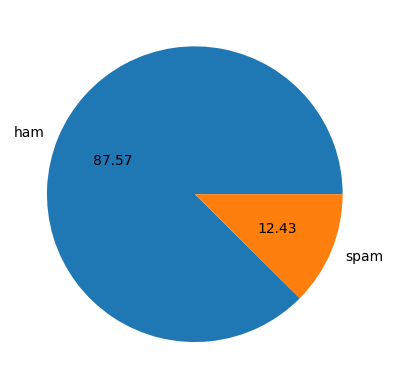

In [63]:
import matplotlib.pyplot as plt
plt.pie(df['target'].value_counts(), labels=['ham','spam'],autopct="%0.2f")
plt.show()

In [64]:
import nltk
nltk.download('all')


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_r

True

In [65]:
df['num_characters'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))
df['num_sentences'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))
df.head()


,target,text,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [66]:
# ham
df[df['target'] == 0][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.869353,17.267715,1.827724
std,56.708301,13.588065,1.394338
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,53.000000,13.000000,1.000000
75%,91.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [67]:
#spam
df[df['target'] == 1][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,641.000000,641.000000,641.000000
mean,137.118565,27.667707,2.970359
std,30.399707,7.103501,1.485575
min,7.000000,2.000000,1.000000
25%,130.000000,25.000000,2.000000
50%,148.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,223.000000,46.000000,9.000000


<Axes: xlabel='num_characters', ylabel='Count'>

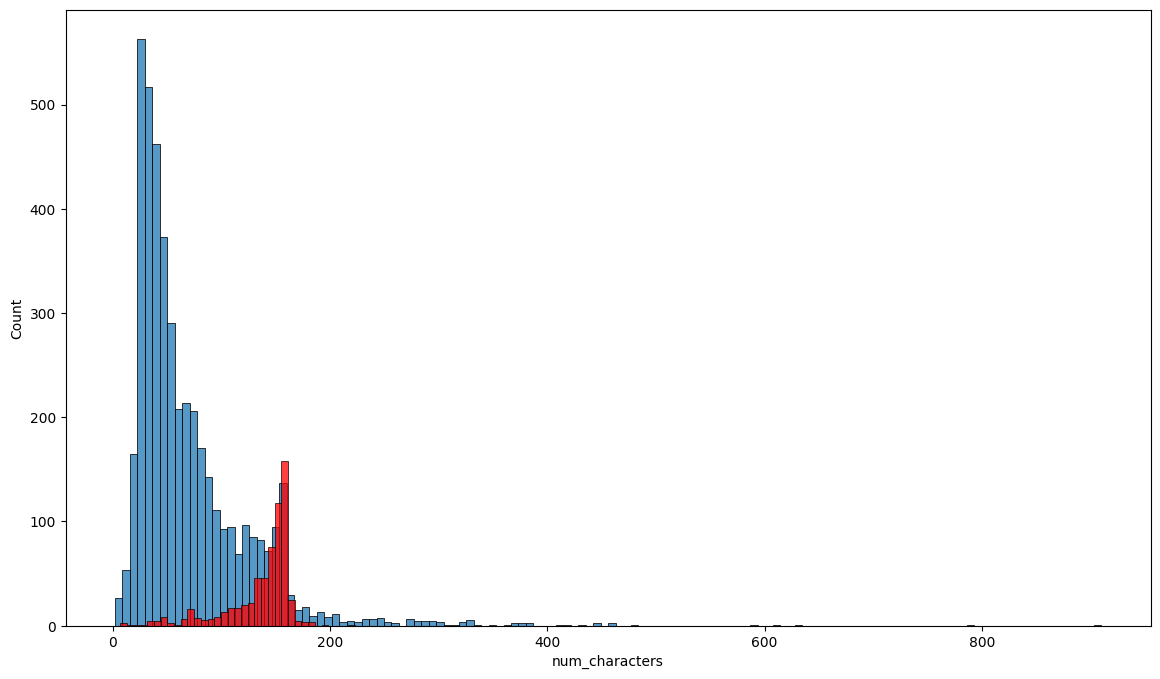

In [68]:
plt.figure(figsize=(14,8))
sns.histplot(df[df['target'] == 0]['num_characters'])
sns.histplot(df[df['target'] == 1]['num_characters'],color='red')

<Axes: xlabel='num_words', ylabel='Count'>

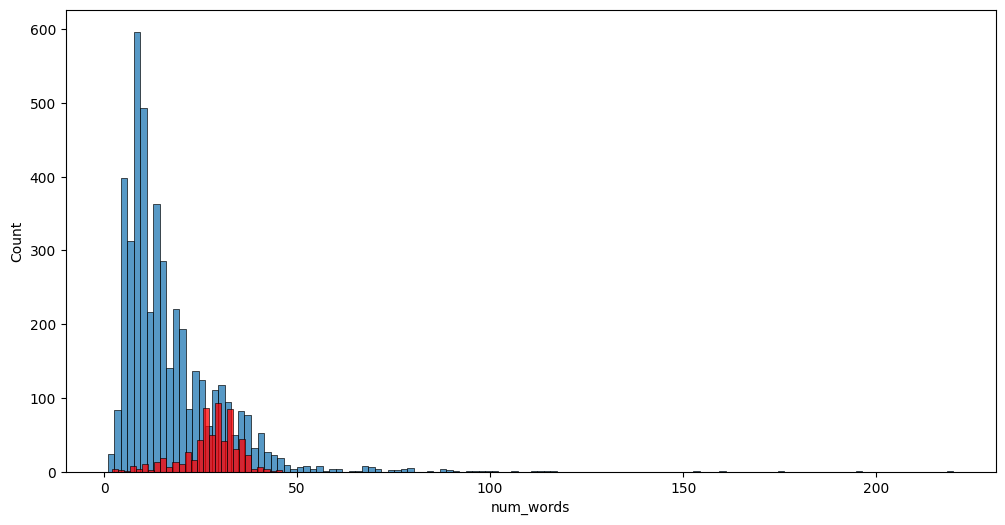

In [69]:
plt.figure(figsize=(12,6))
sns.histplot(df[df['target'] == 0]['num_words'])
sns.histplot(df[df['target'] == 1]['num_words'],color='red')

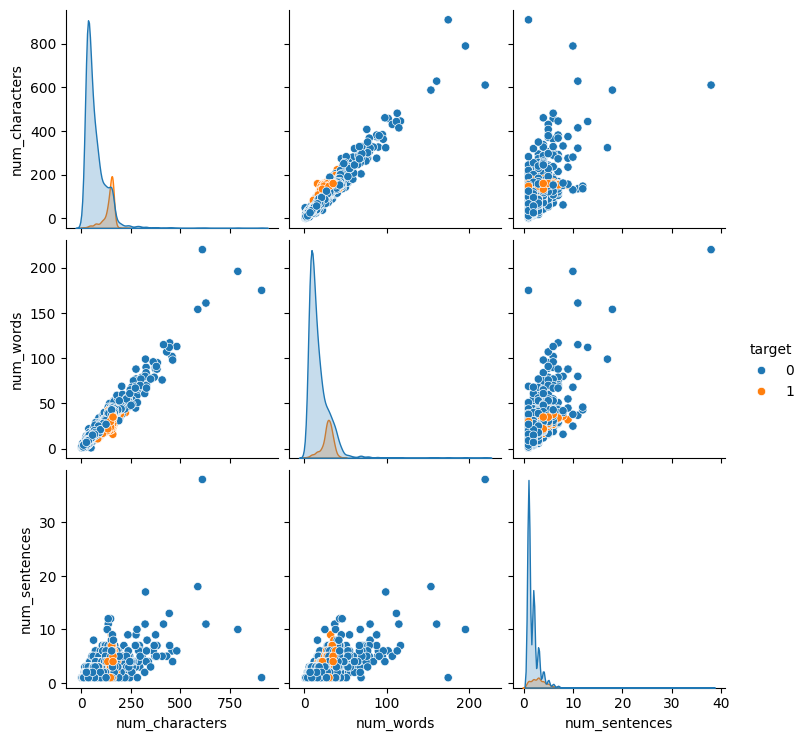

In [70]:
sns.pairplot(df,hue='target')

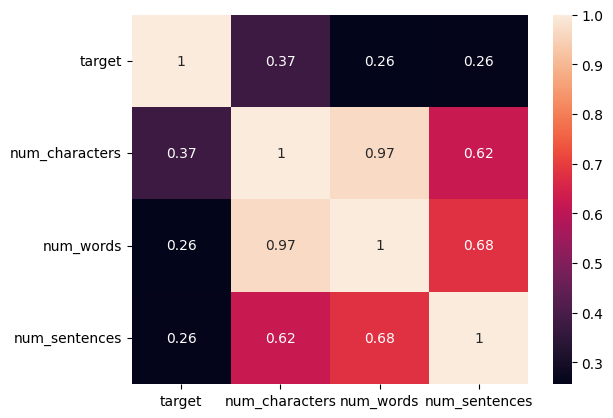

In [71]:
numeric_df = df.select_dtypes(include=['int64', 'float64'])
sns.heatmap(numeric_df.corr(), annot=True)
plt.show()

# **Data Preprocessing**

In [72]:
ps = PorterStemmer()

def transform_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words = nltk.word_tokenize(text)
    filtered = [ps.stem(word) for word in words if word not in stopwords.words('english') and word not in string.punctuation]
    return " ".join(filtered)

df['transformed_text'] = df['text'].apply(transform_text)
df[['text', 'transformed_text']].head()


,text,transformed_text
0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entri wkli comp win fa cup final tkt st m...
3,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,"Nah I don't think he goes to usf, he lives aro...",nah think goe usf live around though


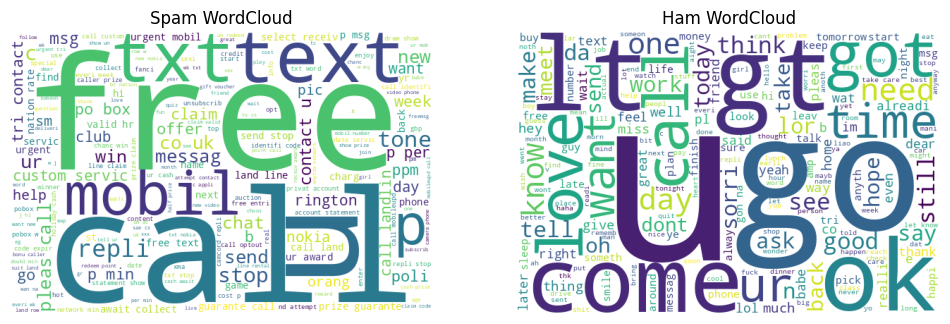

In [73]:
spam_wc = WordCloud(width=600, height=400, background_color='white').generate(
    df[df['target'] == 1]['transformed_text'].str.cat(sep=" ")
)
ham_wc = WordCloud(width=600, height=400, background_color='white').generate(
    df[df['target'] == 0]['transformed_text'].str.cat(sep=" ")
)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(spam_wc)
plt.title("Spam WordCloud")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(ham_wc)
plt.title("Ham WordCloud")
plt.axis("off")
plt.show()


In [74]:
from collections import Counter

spam_words = []
for msg in df[df['target'] == 1]['transformed_text'].tolist():
    spam_words.extend(msg.split())

ham_words = []
for msg in df[df['target'] == 0]['transformed_text'].tolist():
    ham_words.extend(msg.split())

print("Spam Top 10 Words:", Counter(spam_words).most_common(10))
print("Ham Top 10 Words:", Counter(ham_words).most_common(10))


Spam Top 10 Words: [('call', 337), ('free', 192), ('p', 154), ('u', 151), ('txt', 150), ('text', 129), ('ur', 119), ('mobil', 117), ('stop', 115), ('repli', 104)]
Ham Top 10 Words: [('u', 938), ('go', 412), ('get', 358), ('gt', 288), ('lt', 287), ('come', 280), ('ok', 256), ('call', 242), ('got', 240), ('like', 238)]


# **Model Building**

In [76]:
tfidf = TfidfVectorizer(max_features=3000)
X = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values
X.shape


(5157, 3000)

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [78]:
mnb = MultinomialNB()
mnb.fit(X_train, y_train)
y_pred_mnb = mnb.predict(X_test)

print("Multinomial Naive Bayes:\n")
print(classification_report(y_test, y_pred_mnb))


Multinomial Naive Bayes:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       0.99      0.85      0.92       149

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



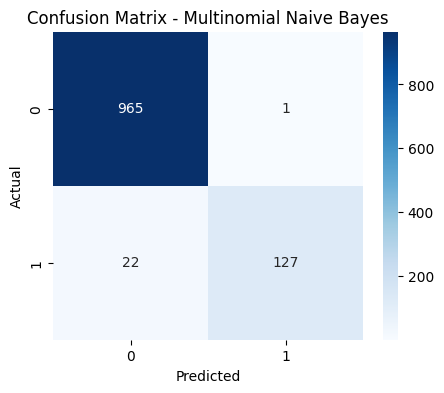

In [79]:
cm = confusion_matrix(y_test, y_pred_mnb)  # Change to mnb or svm if needed

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Multinomial Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [80]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression:\n")
print(classification_report(y_test, y_pred_lr))


Logistic Regression:

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       966
           1       1.00      0.77      0.87       149

    accuracy                           0.97      1115
   macro avg       0.98      0.88      0.92      1115
weighted avg       0.97      0.97      0.97      1115



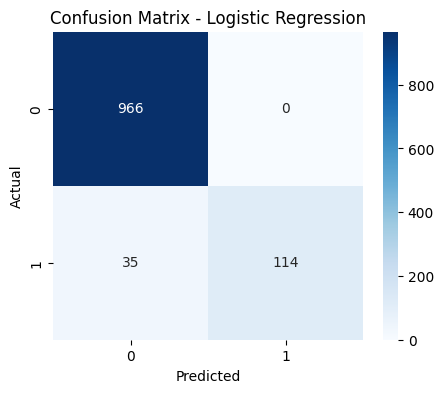

In [81]:
cm = confusion_matrix(y_test, y_pred_lr)  # Change to mnb or svm if needed

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [82]:
svm = SVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("Support Vector Machine:\n")
print(classification_report(y_test, y_pred_svm))


Support Vector Machine:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       966
           1       1.00      0.85      0.92       149

    accuracy                           0.98      1115
   macro avg       0.99      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115



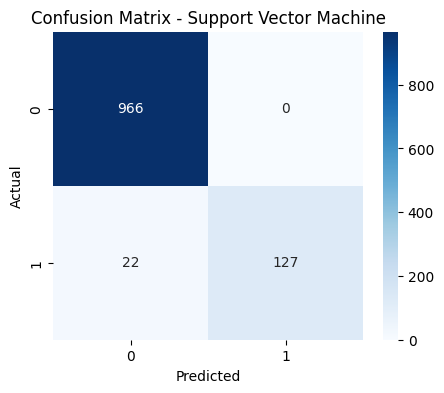

In [83]:
cm = confusion_matrix(y_test, y_pred_svm)  # Change to mnb or svm if needed

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Support Vector Machine")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [84]:
with open('model.pkl', 'wb') as f:
    pickle.dump(lr, f)

with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)


In [1]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package wordnet to C:\Users\Ahmad
[nltk_data]     Ali\AppData\Roaming\nltk_data...
[nltk_data] Downloading package omw-1.4 to C:\Users\Ahmad
[nltk_data]     Ali\AppData\Roaming\nltk_data...


True

In [2]:
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # remove punctuation/numbers
    words = text.split()
    words = [word for word in words if word not in stopwords.words('english')]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)
